In [ ]:
from datetime import datetime
import numpy as np
import pandas as pd
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
from sklearn.linear_model import SGDClassifier, LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import StackingClassifier
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score, fbeta_score, classification_report
from sklearn.metrics import make_scorer 
import matplotlib.pyplot as plt
import gensim.downloader as api

import nltk
from nltk.tokenize import word_tokenize
from nltk import pos_tag
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')

from google.colab import drive
drive.mount('/content/gdrive')
dir_name = "/content/gdrive/MyDrive/Thesis/"

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.


Mounted at /content/gdrive


In [ ]:
def get_raw_data(dir_name, file_name):
    #  load data
    data = pd.read_csv('{}{}.csv'.format(dir_name,file_name), encoding = 'latin-1', usecols=['medical_abstract', 'condition_label'])
    data = data.rename(columns={'medical_abstract': 'text', 'condition_label': 'label'})
    le = LabelEncoder()
    data['label'] = le.fit_transform( data['label'])
    return data

raw_train_data = get_raw_data(dir_name + 'datasets/Medical_Abstracts/', 'train')
raw_train_data

,label,text
0,4,Tissue changes around loose prostheses. A cani...
1,0,Neuropeptide Y and neuron-specific enolase lev...
2,1,"Sexually transmitted diseases of the colon, re..."
3,0,Lipolytic factors associated with murine and h...
4,2,Does carotid restenosis predict an increased r...
...,...,...
11545,0,Epirubicin at two dose levels with prednisolon...
11546,0,Four and a half year follow up of women with d...
11547,4,Safety of the transbronchial biopsy in outpati...
11548,2,Interictal spikes and hippocampal somatostatin...


In [ ]:
raw_train_data['text'].is_unique

False

In [ ]:
raw_train_data.drop_duplicates(subset=['text'], inplace=True)
raw_train_data['text'].is_unique

True

In [ ]:
raw_train_data

,label,text
0,4,Tissue changes around loose prostheses. A cani...
1,0,Neuropeptide Y and neuron-specific enolase lev...
2,1,"Sexually transmitted diseases of the colon, re..."
3,0,Lipolytic factors associated with murine and h...
4,2,Does carotid restenosis predict an increased r...
...,...,...
11539,2,Familial eating epilepsy. Eating-related seizu...
11543,3,Deep venous thrombosis in intravenous cocaine ...
11546,0,Four and a half year follow up of women with d...
11547,4,Safety of the transbronchial biopsy in outpati...


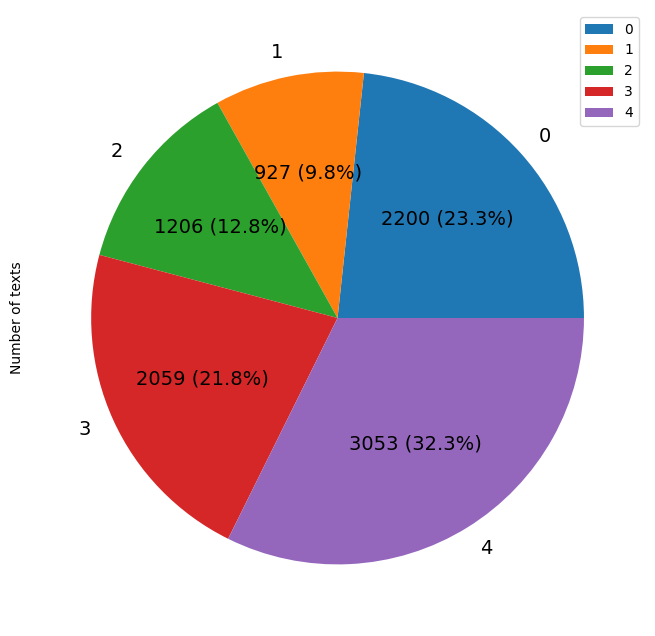

In [ ]:
def get_dataset_statistics(data):
    dataset_statistics = {'Number of texts': [data['label'].value_counts()[0], data['label'].value_counts()[1], data['label'].value_counts()[2], data['label'].value_counts()[3], data['label'].value_counts()[4]]}
    df = pd.DataFrame(dataset_statistics, index=['0', '1', '2', '3', '4'])
    df.plot(kind='pie', y='Number of texts', figsize=(8, 8), fontsize=14,
            autopct=lambda v: '{:.0f} ({:.1f}%)'.format(v / 100 * data['label'].count(), v))
    
# Raw data statistics
get_dataset_statistics(raw_train_data)

In [ ]:
raw_test_data = get_raw_data(dir_name + 'datasets/Medical_Abstracts/', 'test')
raw_test_data

,label,text
0,2,Obstructive sleep apnea following topical orop...
1,4,Neutrophil function and pyogenic infections in...
2,4,A phase II study of combined methotrexate and ...
3,0,Flow cytometric DNA analysis of parathyroid tu...
4,3,Paraneoplastic vasculitic neuropathy: a treata...
...,...,...
2883,3,Management of aortobronchial fistula with graf...
2884,4,Tuberculous psoas muscle abscess following che...
2885,3,Clinical evaluation of high-frequency (ultraso...
2886,0,Antitumor activity of liposome-encapsulated do...


In [ ]:
raw_test_data.drop_duplicates(subset=['text'], inplace=True)
raw_test_data['text'].is_unique

True

In [ ]:
raw_test_data['label'].value_counts()

4    912
0    616
3    589
2    366
1    287
Name: label, dtype: int64

# Text Preprocessing 

In [ ]:
import requests
stopwords_list = requests.get("https://github.com/stopwords-iso/stopwords-en/blob/master/stopwords-en.txt").content
stopwords = set(stopwords_list.decode().splitlines())

In [ ]:
import string
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS
sklearn_stopwords = ENGLISH_STOP_WORDS

stop_words = set(stopwords.words('english'))
stop_words.update(sklearn_stopwords)

def text_preprocessing(raw_text):
  text_words = raw_text.translate(str.maketrans('', '', string.punctuation))
  msg_tokens = word_tokenize(text_words.lower())
  filtered_text = [token for token in msg_tokens if not token in stop_words]
  return " ".join(filtered_text)

In [ ]:
train_data = raw_train_data[['text', 'label']].copy()

train_data['text'] = train_data['text'].apply(text_preprocessing)

train_data.drop_duplicates(inplace=True)

train_data

,text,label
0,tissue changes loose prostheses canine model i...,4
1,neuropeptide neuronspecific enolase levels ben...,0
2,sexually transmitted diseases colon rectum anu...,1
3,lipolytic factors associated murine human canc...,0
4,carotid restenosis predict increased risk late...,2
...,...,...
11539,familial eating epilepsy eatingrelated seizure...,2
11543,deep venous thrombosis intravenous cocaine abu...,3
11546,half year follow women dyskaryotic cervical sm...,0
11547,safety transbronchial biopsy outpatients objec...,4


In [ ]:
test_data = raw_test_data[['text', 'label']].copy()

test_data['text'] = test_data['text'].apply(text_preprocessing)

test_data.drop_duplicates(inplace=True)

test_data

,text,label
0,obstructive sleep apnea following topical orop...,2
1,neutrophil function pyogenic infections bone m...,4
2,phase ii study combined methotrexate teniposid...,4
3,flow cytometric dna analysis parathyroid tumor...,0
4,paraneoplastic vasculitic neuropathy treatable...,3
...,...,...
2883,management aortobronchial fistula graft replac...,3
2884,tuberculous psoas muscle abscess following che...,4
2885,clinical evaluation highfrequency ultrasonic m...,3
2886,antitumor activity liposomeencapsulated doxoru...,0


# Text Representation

In [ ]:
word2vec_model = api.load("word2vec-google-news-300")

[==================================================] 100.0% 1662.8/1662.8MB downloaded


In [ ]:
def get_text_vec(sent):
  vector = np.mean(np.array([word2vec_model[token] for token in word_tokenize(sent) if token in word2vec_model.key_to_index]), axis=0)
  if np.all(np.isnan(vector)) :
    return np.zeros(300)
  return vector

In [ ]:
X_test = np.stack(np.array([get_text_vec(sms_text) for sms_text in test_data['text'].values]))

In [ ]:
X_test.shape

(2770, 300)

In [ ]:
y_test = test_data['label'].values

In [ ]:
y_test.shape

(2770,)

# Model selection, training and evaluation

In [ ]:
def f_beta_score(y_true, y_pred):
  return fbeta_score(y_true, y_pred, beta=2, average='macro')

f2_score = make_scorer(f_beta_score, greater_is_better=True)

In [ ]:
from datetime import datetime

def save_cross_validation(results, file_name):
  results_to_save = pd.DataFrame(columns=['Accuracy', 'Recall', 'Precision', 'F1 Score', 'F2 Score'])
  for i in range(0, 10):
    results_to_save.loc[i] = [
      results['split{}_test_Accuracy'.format(i)][0],
      results['split{}_test_Recall'.format(i)][0],
      results['split{}_test_Precision'.format(i)][0],
      results['split{}_test_F1'.format(i)][0],
      results['split{}_test_F2'.format(i)][0]
    ]
  results_to_save.to_csv('{}Results/{}_{}.csv'.format(dir_name+'experiments/Medical Text/', file_name, datetime.now().strftime("%m%d%H%M")))

In [ ]:
def train_model(classifier, param_grid, model_name, train_texts, train_labels, test_texts, test_labels, evaluation_metrics, to_print=True, to_save=False, file_name=None):
    """
    train email classification model.
    """

    # apply grid search to find best model hyper parameters
    grid_search = GridSearchCV(classifier, param_grid, cv=10, scoring={'Accuracy': make_scorer(accuracy_score),
                                                                       'F1': make_scorer(f1_score, average='macro'),
                                                                       'F2': f2_score,
                                                                       'Recall': make_scorer(recall_score, average='macro'),
                                                                       'Precision': make_scorer(precision_score, average='macro')
                                                                       }, refit='F1', n_jobs=-1)
    grid_search.fit(train_texts, train_labels)
    model = grid_search.best_estimator_

    if to_save:
      ConfusionMatrixDisplay(save_cross_validation(grid_search.cv_results_, file_name))
      plt.show()

    # train and test accuracy.
    test_accuracy = model.score(test_texts, test_labels)
    train_accuracy = model.score(train_texts, train_labels)

    # compute F1 score for model evaluation.
    y_pred = model.predict(test_texts)

    recall = recall_score(test_labels, y_pred, average='macro')
    precision = precision_score(test_labels, y_pred, average='macro')
    f1score = f1_score(test_labels, y_pred, average='macro')
    f2score = fbeta_score(y_test, y_pred, beta=2, average='macro')

    if to_print:
        print("train accuracy = " + str(train_accuracy))
        print("test accuracy = " + str(test_accuracy))
        print("Recall = {}".format(recall))
        print("Precision = {}".format(precision))
        print("F1 score = {}".format(f1score))
        print("F2 score = {}".format(f2score))
        print(classification_report(test_labels, y_pred))


        # plot confusion matrix
        cm = confusion_matrix(test_labels, y_pred)
        disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0,1,2,3,4])

        disp.plot(cmap=plt.cm.Blues)
        plt.show()

        # print best model hyper parameters.
        print(grid_search.best_params_)

    evaluation_metrics.loc[model_name, 'Recall'] = recall
    evaluation_metrics.loc[model_name, 'Precision'] = precision
    evaluation_metrics.loc[model_name, 'F1 score'] = f1score
    evaluation_metrics.loc[model_name, 'F2 score'] = f2score

    return f1score, f2score


def train(model_id, train_texts, train_labels, test_texts, test_labels, evaluation_metrics, to_print=True, to_save=False, file_name=None):
    
    if model_id == 1:
        # Random forest Classification model.
        forest_clf = RandomForestClassifier(random_state=42, n_jobs=-1)
        forest_param_grid = [{'n_estimators': [15,20,25], 'max_features': [10, 15], 'min_samples_split': [15, 20, 25], 'criterion': ['gini','entropy'], 'max_depth': [5, 6]}]
        return train_model(forest_clf, forest_param_grid, 'RandomForest', train_texts, train_labels, test_texts, test_labels, evaluation_metrics, to_print, to_save, file_name)

    if model_id == 2:
        # Support Vector Machine Model.
        svc_clf = SVC(random_state=42)
        svc_param_grid = [{'gamma': ['auto', 'scale'], 'kernel': ['rbf'], 'degree': [3 ,4, 5]}]

        return train_model(svc_clf, svc_param_grid, 'SVM', train_texts, train_labels, test_texts, test_labels, evaluation_metrics, to_print, to_save, file_name)

#Text Aug.

In [ ]:
all_similar_words = {}

def get_similar_words(word):
  if word not in all_similar_words:
    all_similar_words[word] = word2vec_model.most_similar(word)
  return all_similar_words[word]

In [ ]:
import gensim
import random 

class Word2vec:
    """
    A set of functions used to augment data.
    Typical usage: :: 
        >>> from textaugment import Word2vec
        >>> t = Word2vec('path/to/gensim/model'or 'gensim model itself')
        >>> t.augment('I love school')
        i adore school
    """
    
    def __init__(self, **kwargs):
        """
        A method to initialize a model on a given path.
        :type random_state: int, float, str, bytes, bytearray
        :param random_state: seed
        :type model: str or gensim.models.word2vec.Word2Vec
        :param model: The path to the model or the model itself.
        :type runs: int, optional
        :param runs: The number of times to augment a sentence. By default is 1.
        :type v: bool or optional
        :param v: Replace all the words if true. If false randomly replace words.
                Used in a Paper (https://www.cs.cmu.edu/~diyiy/docs/emnlp_wang_2015.pdf)
        :type p: float, optional
        :param p: The probability of success of an individual trial. (0.1<p<1.0), default is 0.5
        """

        # Set random state
        if 'random_state' in kwargs:
            self.random_state = kwargs['random_state']
            if isinstance(self.random_state, int):
                random.seed(self.random_state)
                np.random.seed(self.random_state)
            else:
                raise TypeError("random_state must have type int")

        # Set verbose to false if does not exists
        try:
            if kwargs['v']: 
                self.v = True
            else:
                self.v = False
        except KeyError:
            self.v = False

        try:
            if "p" in kwargs:
                if type(kwargs['p']) is not float:
                    raise TypeError("p represent probability of success and must be a float from 0.1 to 0.9. E.g p=0.5")
                elif type(kwargs['p']) is float:
                    self.p = kwargs['p']
            else:
                kwargs['p'] = 0.5  # Set default value
        except KeyError:
            raise

        # Error handling of given parameters
        try:
            if "runs" not in kwargs:
                kwargs["runs"] = 1  # Default value for runs
            elif type(kwargs["runs"]) is not int:
                raise TypeError("DataType for 'runs' must be an integer")
            if "model" not in kwargs:
                raise ValueError("Set the value of model. e.g model='path/to/model' or model itself")
            if type(kwargs['model']) not in [str,
                                             gensim.models.word2vec.Word2Vec,
                                             gensim.models.keyedvectors.Word2VecKeyedVectors,
                                            gensim.models.keyedvectors.FastTextKeyedVectors]:
                raise TypeError("Model path must be a string. "
                                "Or type of model must be a gensim.models.word2vec.Word2Vec or "
                                "gensim.models.keyedvectors.Word2VecKeyedVectors or "
                                "gensim.models.keyedvectors.FastTextKeyedVectors type. "
                                "To load a model use gensim.models.Word2Vec.load('path')")
        except (ValueError, TypeError):
            raise
        else:
            self.runs = kwargs["runs"] 
            self.model = kwargs["model"]
            self.p = kwargs["p"]
            try:
                if type(self.model) is str:
                    self.model = gensim.models.Word2Vec.load(self.model)
            except FileNotFoundError:
                print("Error: Model not found. Verify the path.\n")
                raise

    def geometric(self, data):
        """
        Used to generate Geometric distribution.
        :type data: list
        :param data: Input data
        :rtype:   ndarray or scalar
        :return:  Drawn samples from the parameterized Geometric distribution.
        """

        data = np.array(data)
        first_trial = np.random.geometric(p=self.p, size=data.shape[0]) == 1  # Capture success after first trial
        return data[first_trial]

    def augment(self, data):
        """
        The method to replace words with similar words.
        
        :type data: str
        :param data: Input data
        :rtype:   str
        :return:  The augmented data
        """
        
        # Avoid nulls and other unsupported types
        if type(data) is not str: 
            raise TypeError("Only strings are supported")
        # Lower case and split
        data_tokens = data.lower().split()

        # Verbose = True then replace all the words.
        if self.v:
            for _ in range(self.runs):
                for index in range(len(data_tokens)):  # Index from 0 to length of data_tokens
                    try:
                        similar_words = [syn for syn, t in self.model.most_similar(data_tokens[index])]
                        r = random.randrange(len(similar_words))
                        data_tokens[index] = similar_words[r].lower()  # Replace with random synonym from 10 synonyms
                    except KeyError:
                        pass  # For words not in the word2vec model
        else:  # Randomly replace some words
            for _ in range(self.runs):
                data_tokens_idx = [[x, y] for (x, y) in enumerate(data_tokens)]  # Enumerate data
                words = self.geometric(data=data_tokens_idx).tolist()  # List of words indexed
                for w in words:
                    try:
                        similar_words_and_weights = [(syn, t) for syn, t in get_similar_words(w[1])]
                        similar_words = [word for word, t in similar_words_and_weights]
                        similar_words_weights = [t for word, t in similar_words_and_weights]
                        word = random.choices(similar_words, similar_words_weights, k=1)
                        data_tokens[int(w[0])] = word[0].lower()  # Replace with random synonym from 10 synonyms
                    except KeyError:
                        pass
            return " ".join(data_tokens)
        return " ".join(data_tokens)

In [ ]:
marivate_augmener = Word2vec(model=word2vec_model, runs=1, v=False, p=0.5)

In [ ]:
def marivate_augmentation(prepro_dataset, lable, sent_num=5):
  texts = prepro_dataset.loc[prepro_dataset['label'] == lable]['text'].values
  texts_num = len(texts)
  new_texts = []
  i = 0
  for text in texts:
    if i % 100 == 0:
      print(f" {int(100*i/texts_num)} %")
    for j in range(sent_num):
      new_texts.append(marivate_augmener.augment(text))
    i += 1
  augmentations = prepro_dataset[['text', 'label']].copy().append(pd.DataFrame({'label':[lable] * len(new_texts), 'text':new_texts}), ignore_index = True)
  augmentations.drop_duplicates(inplace=True)
  return augmentations.sample(frac=1)

In [ ]:
augmented_dataset =  marivate_augmentation(train_data, lable=1, sent_num=1)

 0 %
 10 %
 21 %
 32 %
 43 %
 53 %
 64 %
 75 %
 86 %
 97 %


<ipython-input-27-88e89c9d3031>:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  augmentations = prepro_dataset[['text', 'label']].copy().append(pd.DataFrame({'label':[lable] * len(new_texts), 'text':new_texts}), ignore_index = True)


In [ ]:
augmented_dataset =  marivate_augmentation(augmented_dataset, lable=2, sent_num=1)

 0 %
 8 %
 16 %
 24 %
 33 %
 41 %
 49 %
 58 %
 66 %
 74 %
 82 %
 91 %
 99 %


<ipython-input-27-88e89c9d3031>:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  augmentations = prepro_dataset[['text', 'label']].copy().append(pd.DataFrame({'label':[lable] * len(new_texts), 'text':new_texts}), ignore_index = True)


In [ ]:
augmented_dataset

,text,label
40,modified schollner costoplasty modified scholl...,4
3866,shortterm versus shortterm treatment granulocy...,1
2378,management patients thyroid carcinoma applicat...,0
4183,influence neutralizing heparin carotid endarte...,4
9005,neuropeptide neuronspecific enolase levels ben...,0
...,...,...
6237,endosonography localization parathyroid tumors...,0
5126,primary adenocarcinoma bladder favorable progn...,0
3613,posterior interosseous nerve palsies seventy p...,2
10675,plasma lp_pla2 level teenagers premature cardi...,2


In [ ]:
augmented_dataset.to_csv('{}Marivate_1_1.csv'.format(dir_name+'experiments/Medical Text/'))

In [ ]:
augmented_dataset = pd.read_csv('{}Marivate_1_1.csv'.format(dir_name+'experiments/Medical Text/'))

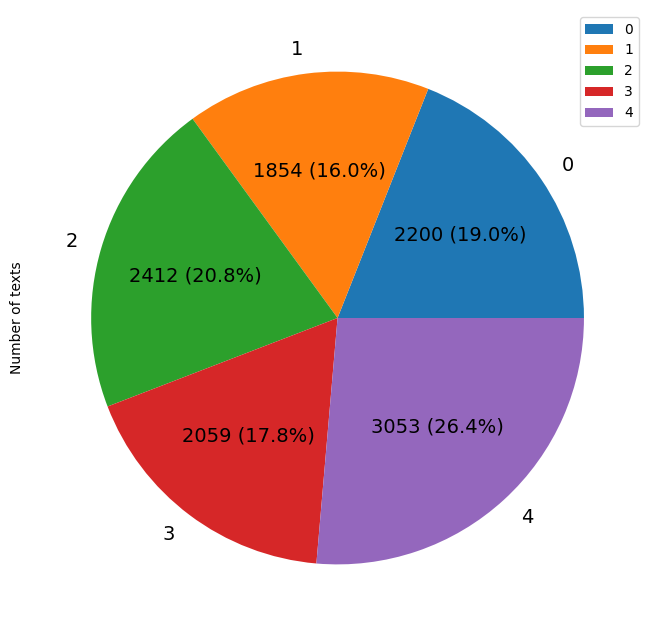

In [ ]:
get_dataset_statistics(augmented_dataset)

In [ ]:
aug_X_train = np.stack(np.array([get_text_vec(sms_text) for sms_text in augmented_dataset['text'].values]))

In [ ]:
aug_X_train.shape

(11578, 300)

In [ ]:
aug_y_train = augmented_dataset['label'].values

In [ ]:
aug_y_train.shape

(11578,)

In [ ]:
evaluation_metrics_aug = pd.DataFrame(columns = ['Recall', 'Precision', 'F1 score', 'F2 score'])

#RF

train accuracy = 0.6256693729486958
test accuracy = 0.5332129963898917
Recall = 0.5094402671390892
Precision = 0.5192184963601851
F1 score = 0.5065315223750464
F2 score = 0.5070610777546815
              precision    recall  f1-score   support

           0       0.66      0.74      0.70       616
           1       0.43      0.22      0.29       287
           2       0.43      0.51      0.47       366
           3       0.64      0.65      0.65       589
           4       0.43      0.43      0.43       912

    accuracy                           0.53      2770
   macro avg       0.52      0.51      0.51      2770
weighted avg       0.53      0.53      0.53      2770



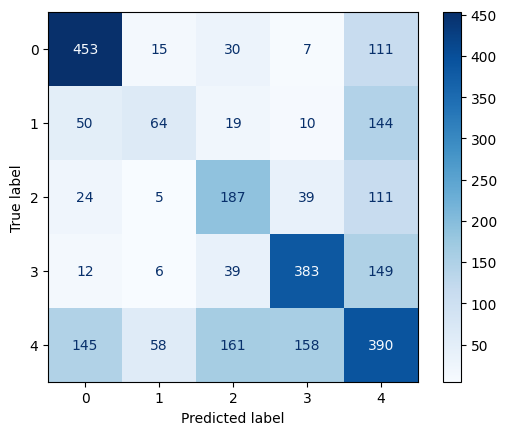

{'criterion': 'entropy', 'max_depth': 6, 'max_features': 15, 'min_samples_split': 15, 'n_estimators': 25}


(0.5065315223750464, 0.5070610777546815)

In [ ]:
train(1, aug_X_train, aug_y_train, X_test, y_test, evaluation_metrics_aug, to_save=True, file_name='Mari_RF')

# SVM

train accuracy = 0.7440836068405596
test accuracy = 0.603971119133574
Recall = 0.6013085508782986
Precision = 0.5933062735091611
F1 score = 0.5961965701007409
F2 score = 0.5989898443517578
              precision    recall  f1-score   support

           0       0.71      0.77      0.74       616
           1       0.49      0.48      0.48       287
           2       0.58      0.55      0.57       366
           3       0.67      0.75      0.71       589
           4       0.51      0.46      0.48       912

    accuracy                           0.60      2770
   macro avg       0.59      0.60      0.60      2770
weighted avg       0.60      0.60      0.60      2770



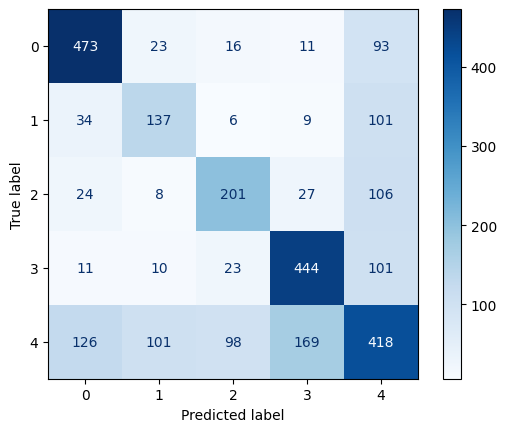

{'degree': 2, 'kernel': 'rbf'}


(0.5961965701007409, 0.5989898443517578)

In [ ]:
train(2, aug_X_train, aug_y_train, X_test, y_test, evaluation_metrics_aug, to_save=True, file_name='Mari_SVM')

In [ ]:
evaluation_metrics_aug

,Recall,Precision,F1 score,F2 score
RandomForest,0.50944,0.519218,0.506532,0.507061
SVM,0.601538,0.592673,0.595882,0.598974


#BiLSTM

In [ ]:
import random
import tensorflow as tf 
from tensorflow import keras 
from tensorflow.keras import layers
from sklearn.metrics import ConfusionMatrixDisplay
from tensorflow.keras.layers import Dropout,SpatialDropout1D
from tensorflow.keras import regularizers
from sklearn.model_selection import StratifiedKFold

In [ ]:
def create_blstm_model(train_texts):

  vectorize_layer = layers.TextVectorization(max_tokens=2000, output_sequence_length=200)

  vectorize_layer.adapt(train_texts)

  embedding_layer = layers.Embedding(input_dim=2000, output_dim=32)

  model = tf.keras.models.Sequential()
  model.add(tf.keras.Input(shape=(1,), dtype=tf.string))
  model.add(vectorize_layer)
  model.add(embedding_layer)
  model.add(SpatialDropout1D(0.2))
  model.add(layers.Bidirectional(layers.LSTM(64, bias_regularizer=regularizers.L2(1e-4), kernel_regularizer=regularizers.L1L2(l1=1e-4, l2=1e-4), activity_regularizer=regularizers.L2(1e-4))))
  model.add(Dropout(0.2))
  model.add(layers.Dense(5, activation='softmax'))


  model.compile(optimizer=keras.optimizers.Adam(),
                loss='sparse_categorical_crossentropy',
                metrics=['accuracy'])  
  print(model.summary())
  
  return model

# Cross Validation

In [ ]:
def cv_blstm():

  kf = StratifiedKFold(10, shuffle=True, random_state=42) 
  cv_metrics = pd.DataFrame(columns = ['Recall', 'Precision', 'F1 score', 'F2 score'])

  fold = 0

  X = augmented_dataset['text'].values
  Y = augmented_dataset['label'].values

  for train, val in kf.split(X, Y):  
  
    print(f"Fold {fold}")

    train_texts = X[train]
    train_labels = Y[train]
    test_texts = X[val]
    test_labels = Y[val]

    blstm_model = create_blstm_model(train_texts)

    history = blstm_model.fit(train_texts,
                              train_labels,
                              epochs=10,
                              batch_size=64,
                              validation_data=(test_texts, test_labels))

    blstm_model.evaluate(test_texts, test_labels)
    y_pred = np.round(blstm_model.predict(test_texts))
    y_pred = np.argmax(y_pred, axis=1)

    f1_sc = f1_score(test_labels, y_pred, average='macro')
    f2score = fbeta_score(test_labels, y_pred, beta=2, average='macro')

    cv_metrics.loc[fold, 'Recall'] = recall_score(test_labels, y_pred, average='macro')
    cv_metrics.loc[fold, 'Precision'] = precision_score(test_labels, y_pred, average='macro')
    cv_metrics.loc[fold, 'F1 score'] = f1_sc
    cv_metrics.loc[fold, 'F2 score'] = f2score
    
    fold += 1

  return cv_metrics

In [ ]:
cv_results = cv_blstm()

Fold 0
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 text_vectorization (TextVec  (None, 200)              0         
 torization)                                                     
                                                                 
 embedding (Embedding)       (None, 200, 32)           64000     
                                                                 
 spatial_dropout1d (SpatialD  (None, 200, 32)          0         
 ropout1D)                                                       
                                                                 
 bidirectional (Bidirectiona  (None, 128)              49664     
 l)                                                              
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                 

In [ ]:
cv_results

,Recall,Precision,F1 score,F2 score
0,0.648144,0.666767,0.643869,0.642228
1,0.669916,0.657444,0.661361,0.665912
2,0.688466,0.675729,0.679723,0.684388
3,0.693317,0.695668,0.681945,0.685247
4,0.664176,0.657799,0.651949,0.656768
5,0.689122,0.679126,0.675106,0.681136
6,0.676339,0.692929,0.669932,0.669219
7,0.678679,0.6722,0.662534,0.66884
8,0.649741,0.67322,0.647143,0.644688
9,0.647607,0.648535,0.633814,0.638151


In [ ]:
cv_results.mean()

Recall       0.670551
Precision    0.671942
F1 score     0.660738
F2 score     0.663658
dtype: float64

In [ ]:
def train_blstm(train_texts, train_labels, test_texts, test_labels):

  blstm_model = create_blstm_model(train_texts)
  
  history = blstm_model.fit(train_texts,
                            train_labels,
                            epochs=10,
                            batch_size=32,
                            validation_data=(test_texts, test_labels))
  
  blstm_model.evaluate(test_texts, test_labels)
  y_pred = np.round(blstm_model.predict(test_texts))

  y_pred = np.argmax(y_pred, axis=1)

  f1_sc = f1_score(test_labels, y_pred, average='macro')
  f2score = fbeta_score(test_labels, y_pred, beta=2, average='macro')

  print("Recall = {}".format(recall_score(test_labels, y_pred, average='macro')))
  print("Precision = {}".format(precision_score(test_labels, y_pred, average='macro')))
  print("F1 score = {}".format(f1_sc))
  print("F2 score = {}".format(f2score))
  print(classification_report(test_labels, y_pred))
  
  cm = confusion_matrix(test_labels, y_pred)

  disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0,1,2,3,4])

  disp.plot(cmap=plt.cm.Blues)
  plt.show()

  return f1_sc

In [ ]:
X_test = test_data['text'].values.reshape(-1, 1)

In [ ]:
y_test = test_data['label'].values

In [ ]:
aug_X_train = augmented_dataset['text'].values.reshape(-1, 1)

In [ ]:
aug_X_train.shape

(11578, 1)

In [ ]:
aug_y_train = augmented_dataset['label'].values.reshape(-1, 1)

In [ ]:
aug_y_train.shape

(11578, 1)

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 text_vectorization_1 (TextV  (None, 200)              0         
 ectorization)                                                   
                                                                 
 embedding_1 (Embedding)     (None, 200, 32)           64000     
                                                                 
 spatial_dropout1d (SpatialD  (None, 200, 32)          0         
 ropout1D)                                                       
                                                                 
 bidirectional_1 (Bidirectio  (None, 128)              49664     
 nal)                                                            
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                      

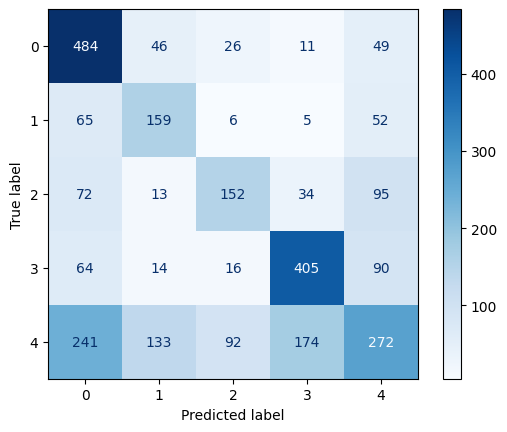

0.5225169917919792

In [ ]:
train_blstm(aug_X_train, aug_y_train, X_test, y_test)